In [ ]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import glob
import os

# Folder containing the files
folder_path = "alphavantage_news_json_byYear"

# Get all files matching the pattern *_2024.json
file_paths = glob.glob(os.path.join(folder_path, "*_2024.json"))

for file_path in file_paths:
    # Extract ticker from filename (e.g., AAPL from AAPL_2024.json)
    ticker = os.path.basename(file_path).split("_")[0]

    # Load the data
    with open(file_path, "r", encoding="utf-8") as f:
        articles = json.load(f)

    # Collect relevance scores
    relevance_scores = []
    for article in articles:
        for sentiment in article.get("ticker_sentiment", []):
            score_str = sentiment.get("relevance_score")
            if score_str is not None:
                try:
                    score = float(score_str)
                    relevance_scores.append(round(score, 2))
                except ValueError:
                    pass

    if not relevance_scores:
        print(f"No relevance scores found in {ticker}_2024.json")
        continue

    # Count frequencies
    score_counts = Counter(relevance_scores)

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.bar(score_counts.keys(), score_counts.values(), width=0.01)
    plt.xlabel("Relevance Score")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Relevance Scores - {ticker} 2024")
    plt.grid(True)
    plt.tight_layout()

    # Show or save the plot
    plt.show()
    # Or to save: plt.savefig(f"{ticker}_2024_relevance_hist.png")

    plt.close()


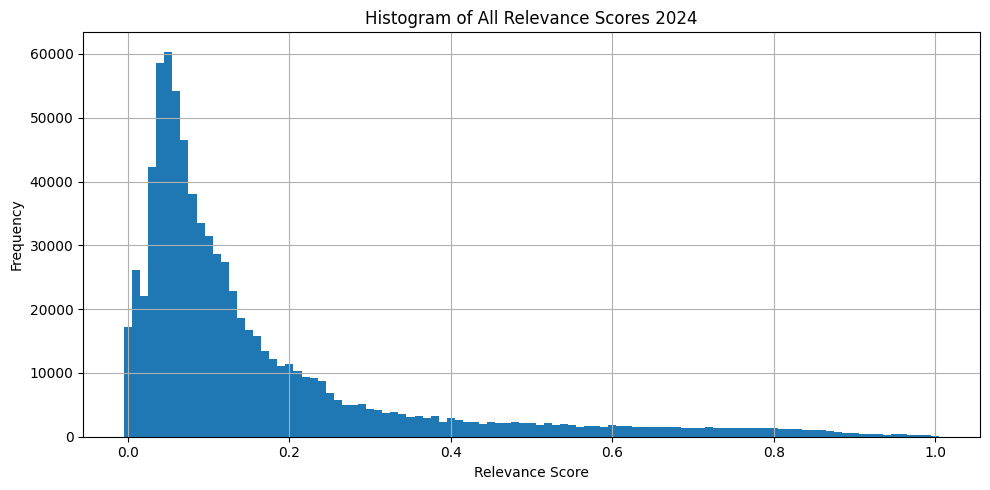

In [17]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import glob
import os

# Folder containing the files
folder_path = "alphavantage_news_json_byYear"

# Get all files matching the pattern *_2024.json
file_paths = glob.glob(os.path.join(folder_path, "*_2024.json"))

all_relevance_scores = []

for file_path in file_paths:
    # Extract ticker from filename (e.g., AAPL from AAPL_2024.json)
    ticker = os.path.basename(file_path).split("_")[0]

    # Load the data
    with open(file_path, "r", encoding="utf-8") as f:
        articles = json.load(f)

    # Collect relevance scores
    ticker_relevance_scores = []

    for article in articles:
        for sentiment in article.get("ticker_sentiment", []):
            score_str = sentiment.get("relevance_score")
            if score_str is not None:
                try:
                    score = float(score_str)
                    ticker_relevance_scores.append(round(score, 2))
                    all_relevance_scores.append(round(score, 2))
                except ValueError:
                    pass

    if not ticker_relevance_scores:
        print(f"No relevance scores found in {ticker}_2024.json")
        continue

# Count frequencies
total_counts = Counter(all_relevance_scores)


# Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(total_counts.keys(), total_counts.values(), width=0.01)
plt.xlabel("Relevance Score")
plt.ylabel("Frequency")
plt.title(f"Histogram of All Relevance Scores 2024")
plt.grid(True)
plt.tight_layout()

# Show or save the plot
plt.show()
# Or to save: plt.savefig(f"{ticker}_2024_relevance_hist.png")

plt.close()


In [16]:
import numpy as np

# Convert relevance_scores to a NumPy array
scores_array = np.array(all_relevance_scores)

# Calculate five-number summary
min_val = np.min(scores_array)
q1 = np.percentile(scores_array, 25)
median = np.median(scores_array)
average = np.average(scores_array)
q3 = np.percentile(scores_array, 75)
max_val = np.max(scores_array)

# Print summary
print(f"Five-number summary for all tickers:")
print(f"Min: {min_val}")
print(f"Q1 : {q1}")
print(f"Median: {median}")
print(f"Average: {average}")
print(f"Q3 : {q3}")
print(f"Max: {max_val}")
print()

Five-number summary for all tickers:
Min: 0.0
Q1 : 0.05
Median: 0.09
Average: 0.16312569834515842
Q3 : 0.19
Max: 1.0



In [ ]:
import os
import json
from os import mkdir
from datetime import datetime

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import random
import time

TICKER_LIST = [] #get from files present in folder alphavantage_news_json_byYear i.e. AAPL_2024.json

# --- User-Agent and headers setup ---
USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:122.0) Gecko/20100101 Firefox/122.0",
]

OUTPUT_FOLDER = f"{datetime.now().strftime('%Y%m%d')}_scraping_AV"

user_agent = random.choice(USER_AGENTS)

# --- Configure headless Chrome ---
options = Options()
#options.add_argument("--headless")  # Run without UI
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument(f"user-agent={user_agent}")
options.add_argument("window-size=1920,1080")

for ticker in TICKER_LIST:
    # --- Launch browser ---
    driver = webdriver.Chrome(options=options)
    try:
        url = f"https://finance.yahoo.com/quote/{ticker}/news/"
        driver.get(url)

        wait = WebDriverWait(driver, 10)

        # --- Accept cookie banner ---
        try:
            cookie_button = wait.until(EC.element_to_be_clickable((By.NAME, "agree")))
            cookie_button.click()
            print("✅ Cookie banner accepted")
            time.sleep(3)
        except:
            print("⚠️ No cookie banner appeared")

        # --- Scroll to load more content ---
        scroll_pause = 2
        last_height = driver.execute_script("return document.body.scrollHeight")

        for _ in range(100):  # Scroll up to 100 times, or break if no new content loaded
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(scroll_pause)

            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break  # Stop scrolling if no more content loads
            last_height = new_height

        print("✅ Finished scrolling")

        # --- Parse content ---
        soup = BeautifulSoup(driver.page_source, "html.parser")
        articles = soup.find_all("div", class_="content yf-1y7058a")

        article_data = []
        for article in articles:
            link = article.find("a", class_="subtle-link")
            if link:
                href = link.get("href")
                title = link.get("title") or link.get_text(strip=True)
                article_data.append({
                    "title": title,
                    "link": href
                })
                print(f"Title: {title}")
                print(f"Link: {href}")
                print("-" * 40)

    finally:
        driver.quit()
        os.makedirs(OUTPUT_FOLDER, exist_ok=True)
        with open(f"{OUTPUT_FOLDER}/{ticker}_news.json", "w", encoding="utf-8") as f:
            json.dump(article_data, f, indent=2, ensure_ascii=False)

    print(f"Number of articles for ticker {ticker}: {len(articles)}")